# Map 2D data

This notebook will have the algorithm for how to map 2D data using the (george package)[https://george.readthedocs.io/en/latest/]. 

>An example of doing this is present in https://gist.github.com/shoyer/80aa06f5ad44aacd9187 (using an older version of george).

The main steps are: 

First things first  
https://nbviewer.jupyter.org/github/adamian/adamian.github.io/blob/master/talks/Brown2016.ipynb

A Gaussian process (GP) is a collection of random variables, any finite number of which have a joint Gaussian distribution.

Equivalently, a GP can be seen as a stochastic process which corresponds to an infinite dimensional Gaussian distribution.



 *Using GP regression to grid ungridded data*

In [1]:
# Load appropriate modules
import george
from george import kernels
from george.kernels import Matern32Kernel

import numpy as np
import matplotlib.pyplot as plt
from itertools import product


In [262]:
# Relevant definitions 

In [3]:
# Optimisation routines

# From first example

from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

In [4]:
# on hyperparameterisation

import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    print(p)
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True, )
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)


In [265]:
def fake_2d_data(n_samples):
    x = np.sqrt(n_samples / 10.0) * np.random.RandomState(12356).rand(n_samples, 2)
    yerr = 0.2 * np.ones_like(x[:, 0])
    y = np.sin(x[:, 0] + x[:, 1]) + yerr * np.random.randn(len(x))
    return x, y





thinking about the time axis 

K&T 2018 - Sum of three Matern / Exp functions describing the covariance of the variable 
1. with reference to lat
2. with reference to lon
3. with reference to time




## following shoyer 

1 Generate 2D data (e.g. could be a 2D function like : sin (x+y) + error ),with some prescribed parameters.
  -- Alternatively, we could just use a test data set that I have for this step that has data that 
  -- is a function of (lat, lon, time), like the Argo data will be.

https://gist.github.com/shoyer/80aa06f5ad44aacd9187

## Using Matern32

Adopted by Park et al 2020  
With the advantage of the results being differentiable


In [348]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T



In [349]:
x.shape

(1000, 2)

In [353]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T

#%time mu, cov = gp.predict(y, test_pts)

kernel = 0.5 * Matern32Kernel(metric=0.5, ndim=2)   #Metric is the length scale (defined in sci-kit learn) of the kernel. 
                                                    #If a float, an isotropic kernel is used.
                                                    #If an array, an anisotropic kernel is used where
                                                    #each dimension of l defines the length-scale of the
                                                    #respective feature dimension. 
# Instead of constant kernal add variance of GP?

kernel = np.var(y) * Matern32Kernel(metric=0.5, ndim=2)
                
# This test data is isotropic, but the ocean is anisotropic

#kernel = 0.5 * Matern32Kernel(metric=[[5,4],[1,5]], ndim=2)  # Example using varying length scales, this is the generarl case
#kernel = kernels.ExpSquaredKernel(metric=[13.0, 0.1],ndim=2)  # Variances in different directions (axis-aligned option)
#(tested here to see how this changes/distorts the estimated field - the optimisation function fixes this! )
# There is a third option, general case, which allows for arbitrary covariances between dimensions (e.g metric = [[12.0, 0.1],[0.1,13.0]])
# Smaller length scales result in more complex functions

print('Parameter vector',kernel.get_parameter_vector())
gpBasic = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
print(x.shape)
gpBasic.compute(x) 

print(y.shape)
print(test_pts.shape)

mu, cov = gpBasic.predict(y, test_pts) # this is where George performs maximum likelihood estimation

Parameter vector [-1.32881023 -0.69314718]
(1000, 2)
(1000,)
(2500, 2)


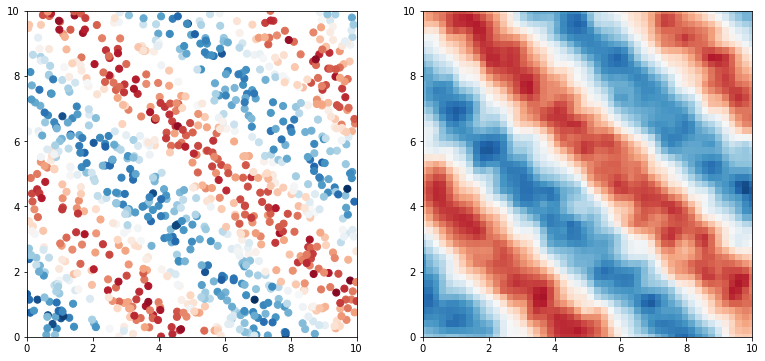

In [268]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

Optimize

In [269]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -187.45


In [330]:
x.shape

(1000, 2)

In [331]:
y.shape

(1000,)

In [332]:
p0

array([-3.32146241, -1.34056218, -0.69314718])

In [333]:
nll

<function __main__.nll(p)>

In [328]:

# You need to compute the GP once before starting the optimization.
gpBasic.compute(x)

# Print the initial ln-likelihood.
print(gpBasic.log_likelihood(y))

# Run the optimization routine.
p0 = gpBasic.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gpBasic.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-196.35489260997844
[-3.32146241 -1.34056218 -0.69314718]
[-3.50629642 -2.00603065  0.03003199]
[-3.12007245 -2.34242652  0.65119168]
[-3.27587102 -2.17905911  0.67326453]
[-3.32295044 -2.00814486  0.83076987]
[-3.3258373  -1.52461235  1.30850811]
[-3.23850552 -0.99370835  1.77828096]
[-3.23812142 -0.62551996  2.14615067]
[-3.24692497 -0.08677637  2.47850179]
[-3.2566348   0.09044517  2.64675206]
[-3.25653952  0.14766641  2.68618855]
[-3.25580432  0.17915751  2.70735227]
[-3.25573589  0.1811901   2.70883738]
[-3.25573139  0.18122701  2.70886589]
-9.079077577126782


In [78]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -8.484262064866812
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([3.05479798e-07, 4.21673256e-07, 6.93393687e-07])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([-3.1313911 ,  0.97408999,  1.00467499])

Final ln-likelihood: 8.48


In [79]:
mu, cov = gp.predict(y, test_pts)

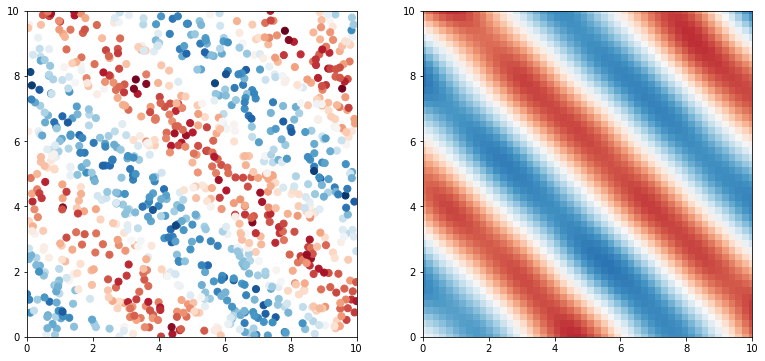

In [80]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

## Set function aligned to xaxis only

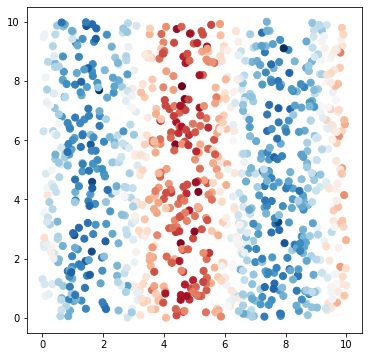

In [97]:
def fake_2d_data_vertical(n_samples):
    x = np.sqrt(n_samples / 10.0) * np.random.RandomState(12356).rand(n_samples, 2)
    yerr = 0.2 * np.ones_like(x[:, 0])
    y = np.sin(x[:, 0]) + yerr * np.random.randn(len(x))
    return x, y

n_samples = 1000
x, y = fake_2d_data_vertical(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T


f, axes = plt.subplots(1, 1, figsize=(6,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes.scatter(x[:, 0], x[:, 1], c=y, s=50, **style)



* * *
Note on lengthscale selection / metric parameters

Isotropic = one values

Anisotropic = axis-aligned nD values
 
Units don't seem to be important.

* * *

Parameter vector [-1.44926136  0.69314718]


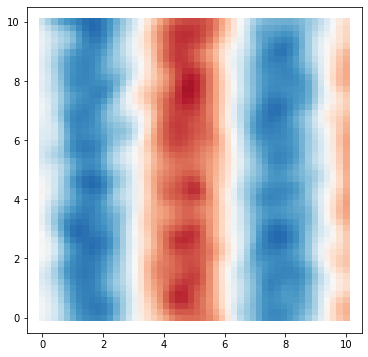

In [109]:
kernel = np.var(y) * Matern32Kernel(metric=2.0, ndim=2)  # make it isotropic

print('Parameter vector',kernel.get_parameter_vector())


gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)



In [110]:
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

print(gp.log_likelihood(y))



102.71840044073616


Parameter vector [1.0593007  4.12703772]


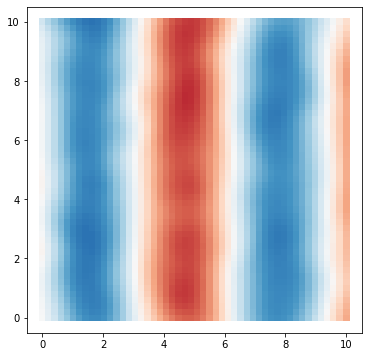

In [111]:
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


print('Parameter vector',kernel.get_parameter_vector())



Parameter vector [-1.44926136  0.69314718  2.7080502 ]
190.0113753720741
Parameter vector [-0.45815611  2.62252532 12.91212571]


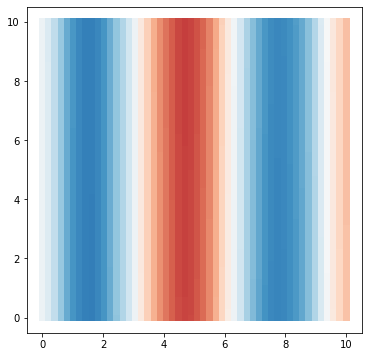

In [115]:
kernel = np.var(y) * Matern32Kernel(metric=[2.0,15], ndim=2)  # now anisotropic

print('Parameter vector',kernel.get_parameter_vector())


gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

#, axes = plt.subplots(1, 1, figsize=(6,6))
#axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

print(gp.log_likelihood(y))

gp.compute(x) 

mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

f, axes = plt.subplots(1, 1, figsize=(6,6))
axes.scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)
#axes.scatter(x[:, 0], x[:, 1], c=y, s=10, **style,edgecolors='k')



print('Parameter vector',kernel.get_parameter_vector())





Moving from isotropic to anisotropic, the parameters converge at a larger third position parameter vector

##  Exponential 
used by K&S 2018

In [385]:
test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=50),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=50))).reshape(2, -1).T



CPU times: user 906 ms, sys: 17.6 ms, total: 924 ms
Wall time: 281 ms


In [386]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

from george import kernels
kernel = 0.5 * kernels.ExpSquaredKernel(0.5, ndim=2) 

gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x)

mu, cov = gp.predict(y, test_pts)

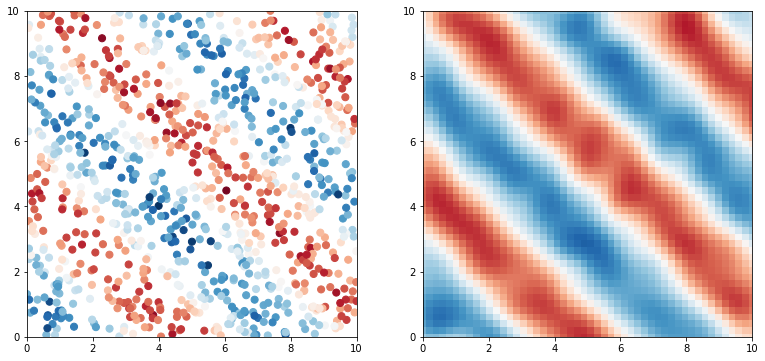

In [387]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

In [388]:
print("Initial ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

Initial ln-likelihood: -90.79


In [389]:
result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: -22.65977231802276
 hess_inv: array([[ 2.14345094e-03, -7.83241794e-05,  3.05084688e-05],
       [-7.83241794e-05,  1.78965538e-01,  5.25559211e-02],
       [ 3.05084688e-05,  5.25559211e-02,  1.91594354e-02]])
      jac: array([-1.49582204e-07, -7.91290660e-08,  5.08045872e-09])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 11
     njev: 14
   status: 0
  success: True
        x: array([-3.15705015, -0.04616422,  1.2045276 ])

Final ln-likelihood: 22.66


In [390]:
mu, cov = gp.predict(y, test_pts)

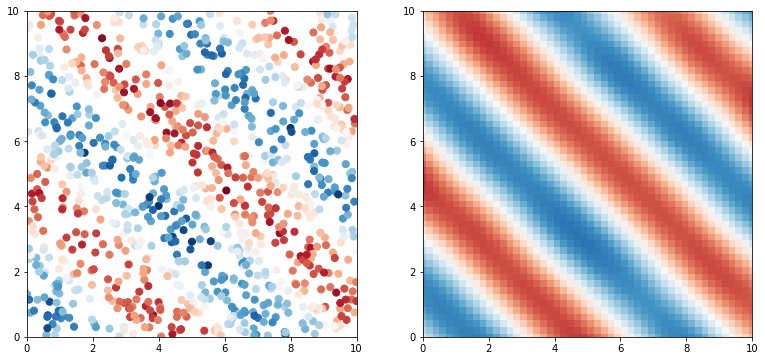

In [391]:
f, axes = plt.subplots(1, 2, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)
axes[0].scatter(x[:, 0], x[:, 1], c=y, s=50, **style)
axes[1].scatter(test_pts[:, 0], test_pts[:, 1], c=mu, s=50, marker='s', edgecolor='none', **style)


for ax in axes:
    ax.set_xlim(0, np.sqrt(n_samples / 10))
    ax.set_ylim(0, np.sqrt(n_samples / 10))

##  -- Decide which kernel to use for argo data



In [ ]:
#https://www.inf.ed.ac.uk/teaching/courses/mlpr/2016/notes/w7c_gaussian_process_kernels.pdf

# A Kernal is a covariance function or how related features are in space / covary with each other

# Choice linked to the distribution/ variability in region to be interpolated?

# Assume local stationarity following K&S 2018 
# Kernels that are stationary
# W&S present an anisotropic exponential space-time covariance function  - this would then allow for 3d ?

# Is it nessecary to emulate kernel from Eq 3.2 of K&S 2018 ?


## Anticipate the need to scale up

### George provides an approximate solver

In [ ]:
#Testing this out
#Compare previous to approximate solver, solutions similar, does speed things up 

In [38]:
n_samples = 1000
x, y = fake_2d_data(n_samples)

test_pts = np.array(np.meshgrid(np.linspace(0, np.sqrt(n_samples / 10.), num=75),
                                np.linspace(0, np.sqrt(n_samples / 10.), num=75))).reshape(2, -1).T

#%time mu, cov = gp.predict(y, test_pts)

kernel = 0.5 * Matern32Kernel(0.5, ndim=2) 

In [39]:
gp = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True)
%time gp.compute(x)

%time mu, cov = gp.predict(y, test_pts)

CPU times: user 39.7 ms, sys: 3.61 ms, total: 43.3 ms
Wall time: 28.9 ms
CPU times: user 3.63 s, sys: 145 ms, total: 3.77 s
Wall time: 1.24 s


In [40]:
 # quicker on the compute part 
gp_hodlr = george.GP(kernel,white_noise=np.log(0.19**2), fit_white_noise=True,solver=george.HODLRSolver, seed=42)
%time gp_hodlr.compute(x)
print(gp_hodlr.log_likelihood(y))

%time mu, cov = gp.predict(y, test_pts)

CPU times: user 8.71 ms, sys: 1.17 ms, total: 9.89 ms
Wall time: 9.53 ms
-501.78775542089306
CPU times: user 3.41 s, sys: 195 ms, total: 3.6 s
Wall time: 1.32 s


### Moving Window  

In [ ]:
# how did they do this? Nearest neightbours, Quadtree?  


## Try out some ARGO data

In [5]:
import xarray as xr

datafile='/Users/isabelle/Documents/coursework/oceanhackweek2020/ohw20-proj-argo-mapping/anom_data.nc'
ds = xr.open_dataset(datafile)

In [160]:
print(ds.Time.min(), ds.Time.max())
print(ds.Lon.min(), ds.Lon.max())
print(ds.Lat.min(), ds.Lat.max())

<xarray.DataArray 'Time' ()>
array('2004-05-04T22:47:06.999981824', dtype='datetime64[ns]') <xarray.DataArray 'Time' ()>
array('2017-12-31T15:18:25.000001280', dtype='datetime64[ns]')
<xarray.DataArray 'Lon' ()>
array(-144.998) <xarray.DataArray 'Lon' ()>
array(-135.00124)
<xarray.DataArray 'Lat' ()>
array(-54.998) <xarray.DataArray 'Lat' ()>
array(-45.00263)


In [6]:
# Change time to ordinal? 

import pandas as pd
pydatetime = pd.to_datetime(pd.Series(ds.Time.values.squeeze()))
ord=pydatetime.apply(lambda x: x.toordinal())

In [7]:
## Argo data 
# Argo anomaly data
ds = xr.open_dataset(datafile)
num_samples = len(ds.r)
Xinput = np.zeros((num_samples, 3)) # 3 coordinates for lon, lat, time
Xinput[:,0] = ds.Lon.values
Xinput[:,1] = ds.Lat.values
Xinput[:,2] = ord
Yinput = ds.Data.isel(c=0).values
Xinput = xr.DataArray(Xinput, dims=["samplenum", "coordinate"], coords=[range(num_samples), ['lon','lat','time']]).rename('Input_coordinates')
Yinput = xr.DataArray(Yinput, dims=["samplenum"]).rename('Anomaly_data')
Argo_input = xr.merge([Xinput, Yinput])
Argo_input

<xarray.Dataset>
Dimensions:            (coordinate: 3, samplenum: 4089)
Coordinates:
  * samplenum          (samplenum) int64 0 1 2 3 4 ... 4084 4085 4086 4087 4088
  * coordinate         (coordinate) <U4 'lon' 'lat' 'time'
Data variables:
    Input_coordinates  (samplenum, coordinate) float64 -144.4 ... 7.366e+05
    Anomaly_data       (samplenum) float64 -0.2994 -0.2045 ... -0.3255 -0.5773

In [16]:
# Use a subset
subset = Argo_input.isel(samplenum=slice(0,2000))
y=np.array(subset.Anomaly_data.squeeze())
x=np.array(subset.Input_coordinates[:,:2].squeeze())

In [17]:
# Grid points

# 2d case, ignore time dimension

grid_pts_2d = np.array(np.meshgrid(np.linspace(np.nanmin(subset.Input_coordinates[:,0]),np.nanmax(subset.Input_coordinates[:,0]), 30),
                                np.linspace(np.nanmin(subset.Input_coordinates[:,1]),np.nanmax(subset.Input_coordinates[:,1]), 30))).reshape(2, -1).T

In [18]:
#kernel = np.array(np.var(y))* Matern32Kernel(metric=0.5, ndim=2)
kernel =  Matern32Kernel(metric=0.5, ndim=2)

In [19]:
# Optimise
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(np.array(y), quiet=True, )
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

In [20]:
# Use George HODLRSolver   # optimisation makes it worse???
%time

gp = george.GP(kernel,solver=george.HODLRSolver, seed=42)#,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x)

%time
predHODLR, pred_varHODLR = gp.predict(y,grid_pts_2d , return_var=True)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

gp.compute(x)


predHODLR, pred_varHODLR = gp.predict(y,grid_pts_2d , return_var=True)



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
-1080.8922284889243
9033.986679221856


In [21]:
%time
gp = george.GP(kernel)#,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x)

%time
predBasic, pred_varBasic = gp.predict(y,grid_pts_2d , return_var=True)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))


predBasic, pred_varBasic = gp.predict(y,grid_pts_2d , return_var=True)

CPU times: user 28 µs, sys: 0 ns, total: 28 µs
Wall time: 5.96 µs
CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 4.77 µs
-13234.034537175641
-1562.508224827274


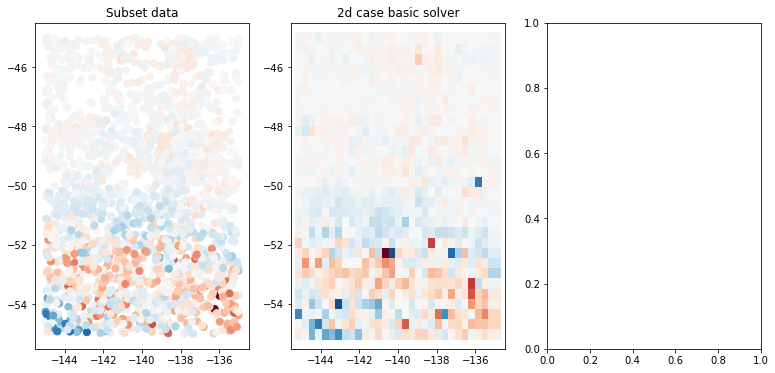

In [24]:
f, axes = plt.subplots(1, 3, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)

axes[0].set_title('Subset data')
cs=axes[0].scatter(subset.Input_coordinates[:, 0],subset.Input_coordinates[:, 1], c=subset.Anomaly_data, s=50, **style)

axes[1].set_title('2d case basic solver')


axes[1].scatter(grid_pts_2d[:, 0], grid_pts_2d[:, 1], c=predBasic, s=150, marker='s', edgecolor='none', **style)

#axes[2].set_title('2d case holdr solver')

#axes[2].scatter(grid_pts_2d[:, 0], grid_pts_2d[:, 1], c=predHODLR, s=150, marker='s', edgecolor='none', **style)
#plt.colorbar(cs)


In [ ]:
# 3d case 

In [470]:
x3d = np.array(subset.Input_coordinates[:,:].squeeze())

In [507]:
# Grid points

grid_pts_3d = np.array(np.meshgrid(np.linspace(np.nanmin(subset.Input_coordinates[:,0]),np.nanmax(subset.Input_coordinates[:,0]), 30),
                                np.linspace(np.nanmin(subset.Input_coordinates[:,1]),np.nanmax(subset.Input_coordinates[:,1]), 30),
                                np.linspace(np.nanmin(subset.Input_coordinates[:,2]),np.nanmax(subset.Input_coordinates[:,2]), 30))).reshape(3, -1).T

In [509]:
grid_pts_3d.reshape(30,30,30,-1)


array([[[[-1.44979996e+02, -5.49980000e+01,  7.31705000e+05],
         [-1.44979996e+02, -5.49980000e+01,  7.31876724e+05],
         [-1.44979996e+02, -5.49980000e+01,  7.32048448e+05],
         ...,
         [-1.44979996e+02, -5.49980000e+01,  7.36341552e+05],
         [-1.44979996e+02, -5.49980000e+01,  7.36513276e+05],
         [-1.44979996e+02, -5.49980000e+01,  7.36685000e+05]],

        [[-1.44636203e+02, -5.49980000e+01,  7.31705000e+05],
         [-1.44636203e+02, -5.49980000e+01,  7.31876724e+05],
         [-1.44636203e+02, -5.49980000e+01,  7.32048448e+05],
         ...,
         [-1.44636203e+02, -5.49980000e+01,  7.36341552e+05],
         [-1.44636203e+02, -5.49980000e+01,  7.36513276e+05],
         [-1.44636203e+02, -5.49980000e+01,  7.36685000e+05]],

        [[-1.44292410e+02, -5.49980000e+01,  7.31705000e+05],
         [-1.44292410e+02, -5.49980000e+01,  7.31876724e+05],
         [-1.44292410e+02, -5.49980000e+01,  7.32048448e+05],
         ...,
         [-1.44292410e+0

In [481]:
grid_pts_3d.shape

(27000, 3)

In [482]:
kernel3d = np.var(y) * Matern32Kernel(metric=0.5, ndim=3)
kernel3d

ConstantKernel(log_constant=-3.5351812575607338, ndim=3, axes=array([0, 1, 2])) * Matern32Kernel(metric=Metric(0.5, ndim=3, axes=array([0, 1, 2]), bounds=[(None, None)]), block=None)

In [528]:
# Use George Basic Solver
%time
gp = george.GP(kernel3d)#,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x3d)

%time
predBasic, pred_varBasic = gp.predict(y,grid_pts_3d , return_var=True)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

gp.compute(x3d)
predBasic, pred_varBasic = gp.predict(y,grid_pts_3d , return_var=True)




CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
-83.55213667322337
-70.12025147299244


In [527]:
# Use George HODLRSolver
%time
gp = george.GP(kernel3d,solver=george.HODLRSolver, seed=42)#,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x3d)

%time
predHODLR, pred_varHODLR = gp.predict(y,grid_pts_3d , return_var=True)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))
# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

gp.compute(x3d)
predHODLR, pred_varHODLR = gp.predict(y,grid_pts_3d , return_var=True)



CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
42.39564149009735
72.62634377484744


In [493]:
27000/3

9000.0

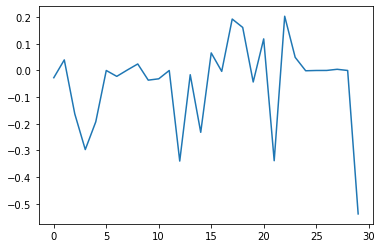

In [545]:
pred=np.reshape(predBasic,(30,30,30,-1))
plt.plot(pred[1,1,:,0])
plt.plot(pred[1,1,:,0])



In [512]:
grid_pts_3d.reshape(30,30,30,-1).shape



(30, 30, 30, 3)

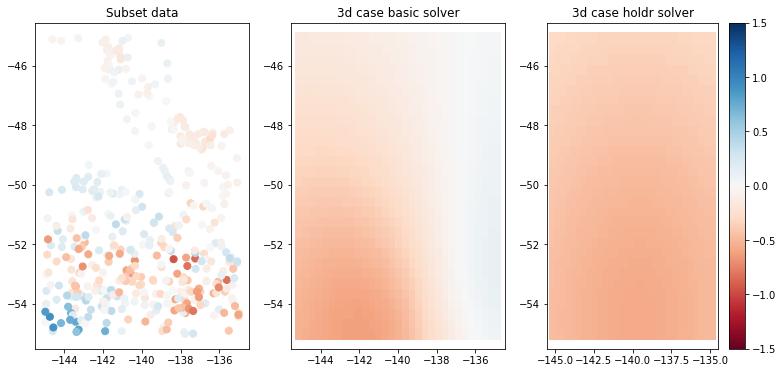

In [487]:
f, axes = plt.subplots(1, 3, figsize=(13,6))

style = dict(cmap='RdBu', vmin=-1.5, vmax=1.5)

axes[0].set_title('Subset data')
cs=axes[0].scatter(subset.Input_coordinates[:, 0],subset.Input_coordinates[:, 1], c=subset.Anomaly_data, s=50, **style)

axes[1].set_title('3d case basic solver')


axes[1].scatter(grid_pts_3d[:, 0], grid_pts_3d[:, 1], c=predBasic, s=150, marker='s', edgecolor='none', **style)

axes[2].set_title('3d case holdr solver')

axes[2].scatter(grid_pts_3d[:, 0], grid_pts_3d[:, 1], c=predHODLR, s=150, marker='s', edgecolor='none', **style)
plt.colorbar(cs)

In [240]:
op.minimize?

In [247]:
# Print the initial ln-likelihood.
print(gp.log_likelihood(subset.Anomaly_data))

# Run the optimization routine.
p0 = gp.get_parameter_vector()

print(p0)
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
#gp.set_parameter_vector(results.x)
#print(gp.log_likelihood(y))

-265.0224831955147
[-1.79175947 -0.69314718]


ValueError: Dimension mismatch

In [232]:
result = minimize(neg_ln_like, gpHODLR.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gpHODLR.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gpHODLR.log_likelihood(subset.Anomaly_data)))

ValueError: Dimension mismatch

In [ ]:
%time
predHODLR, pred_varHODLR = gpHODLR.predict(subset.Anomaly_data,test_pts_3d , return_var=True)

In [105]:
from itertools import product
x1 = ds.Lon.squeeze()[200:300]
x2 = ds.Lat.squeeze()[200:300]
t1 = ds.Time.squeeze()[200:300]
y = np.array(ds.Data.squeeze()[200:300])

In [108]:
X = np.array([x1,x2,ord]).T

In [109]:
X.shape

(100, 3)

In [111]:
test_pts.shape

(8000, 3)

In [112]:
y.shape

(100,)

In [113]:
kernel = 0.5 * Matern32Kernel(metric=0.5, ndim=3)

In [114]:
gp = george.GP(kernel)#,white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(X)

In [115]:
#x1x2t1 = np.array(list(product(x1, x2, t1)))

In [116]:
pred, pred_var = gp.predict(y, X, return_var=True)

In [117]:
pred_var

array([1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
       1.25005561e-12, 1.25005561e-12, 1.25005561e-12, 1.25005561e-12,
      

In [84]:
mu, cov = gp.predict(y, test_pts) # this is where George performs maximum likelihood estimation

(100,)

TypeError: scatter() got multiple values for keyword argument 'vmin'

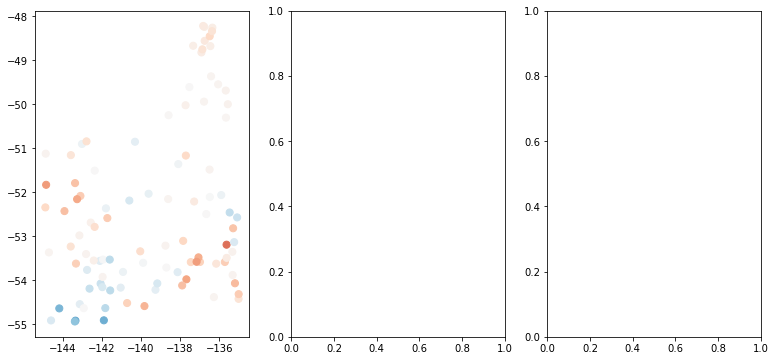

In [127]:



#for ax in axes:
#    ax.set_xlim(0, np.sqrt(n_samples / 10))
#    ax.set_ylim(0, np.sqrt(n_samples / 10))

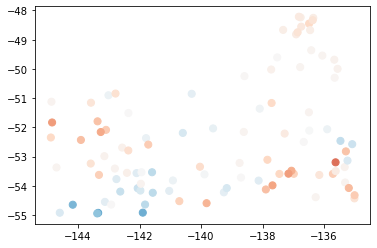

In [119]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, **style)